In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [18]:
mask = glob(r"C:\Users\JAYANKONDAN\Downloads\brain_tumor_custom\Mask\*")
tumor = glob(r"C:\Users\JAYANKONDAN\Downloads\brain_tumor_custom\Tumor\*")

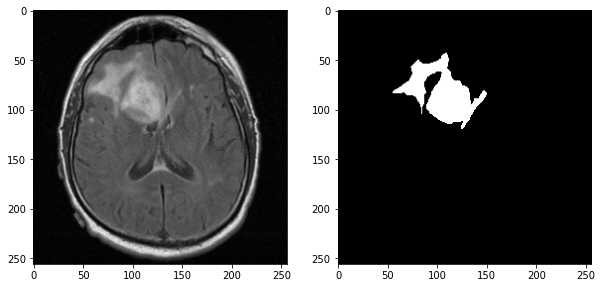

In [98]:
img = cv2.imread(tumor[1],0)
msk = cv2.imread(mask[1])
fig = plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(msk, cmap="gray")

# thresholding

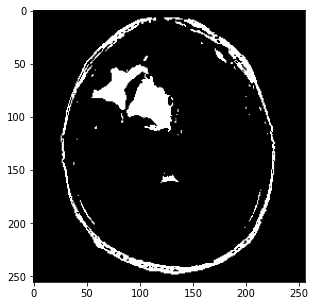

In [99]:
im1 = (img>90) * (img<150) #90 to 150
fig = plt.figure(figsize=(5,5))
plt.imshow(im1,cmap="gray")

# canny edge

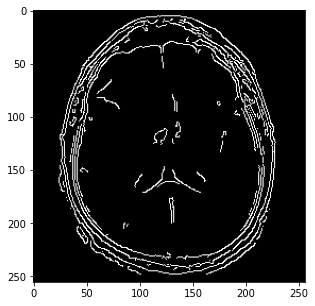

In [111]:
edges = cv2.Canny(img, 100, 150)
fig = plt.figure(figsize=(5,5))
plt.imshow(edges, cmap="gray")

# region growing

In [129]:
def region_growing(image, seed_point, threshold):
    segmented = np.zeros_like(image, dtype=np.uint8)
    connectivity = [(x, y) for x in range(-1, 2) for y in range(-1, 2) if (x != 0 or y != 0)]
    queue = [seed_point]

    while queue:
        current_pixel = queue.pop(0)
        if (0 <= current_pixel[0] < image.shape[0]) and (0 <= current_pixel[1] < image.shape[1]):
            if segmented[current_pixel] == 0 and abs(int(image[current_pixel]) - int(image[seed_point])) <= threshold:
                segmented[current_pixel] = 255
                for dx, dy in connectivity:
                    neighbor_pixel = (current_pixel[0] + dx, current_pixel[1] + dy)
                    queue.append(neighbor_pixel)
    return segmented

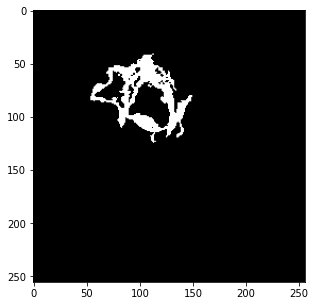

In [139]:
out = region_growing(img, (100,100), 15)
fig = plt.figure(figsize=(5,5))
plt.imshow(out, cmap="gray")

# kmeas

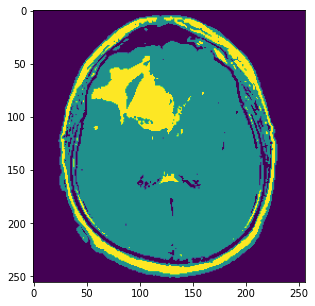

In [149]:
def kmeans_segmentation(image, k):
    pixels = image.reshape((-1,1))
    pixels = np.float32(pixels)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    labels = labels.flatten()
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image

out1 = kmeans_segmentation(img, 3)
fig = plt.figure(figsize=(5,5))
plt.imshow(out1)

# unet 
from pytorch documentation

In [155]:
from torchvision import transforms
import torch

In [157]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
model

Using cache found in C:\Users\JAYANKONDAN/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

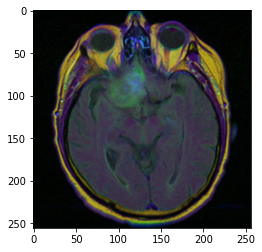

In [178]:
img = cv2.imread(tumor[0])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [185]:
m, s = np.mean(img, axis=(0, 1)), np.std(img, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(img*(img>150))
input_batch = input_tensor.unsqueeze(0)
input_batch.shape

torch.Size([1, 3, 256, 256])

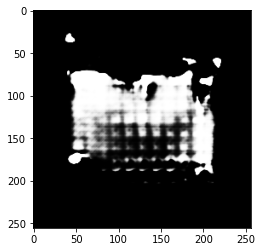

In [189]:
out = model(input_batch)
plt.imshow(out.detach().numpy().reshape(256,256), cmap="gray")